In this analysis, I want to look into the stereotype that men prefer a more "violent" strategy that prefers more hits resulting in fewer rocks in play (also known as "keeping it clean"), while women prefer a more "finesse" strategy, with fewer hits resulting in more rocks in play (also known as "the junk game").

In curling game strategy, outside of this gender stereotype there is another important reason why a team might prefer to "play the junk game".  When a team is less skilled, this typically means that they can't hit with accuracy matching a more experienced team, and may try to force the junk game (through taking careful advance of the 4 rock free guard zone rule) so they have a better chance of winning.  Although this would also be an interesting avenue of inquiry, I don't believe that it is necessary to disentangle for a robust first analysis for the following reasons:
* This dataset is of world championship level games, so the skill of the teams playing should already be pretty high.
* There definitely will be differences of skill between teams.  Our preliminary analysis showed teams from several countries playing many more games than other countries (nominally because they qualify for the world championship competitions more frequently.)  However, there should be a similar distribution of skill levels in both Men's and Women's games, so if there is a difference between the strategy preferences of Men and Women, it should appear in aggregate.

Of course, a future analysis could explore varying skill levels in more detail (e.g. restricting to semi-final and final games guarantees the highest-skilled teams are being compared, or comparing the shot accuracy statistics for the teams in each game.)  However, since any difference between the Men and the Women preferred strategy should appear in aggregate, we will start with a simple comparison between the Men's games and the Women's games.

This dataset gives us two possible directions for making this comparison:
1. "Shot Type": The "type" column in the shots table gives the type of shot (Draws and Guards, for example being more finessed, and Take-outs and Clearing being examples of hits.)  If Men and Women prefer the same strategy, we'd expect the distribution of shot types to be the same for Men as for Women.
2. "Stones in Play": The stone_positions table stores the positions of all the stones in play.  If Women truly do prefer a strategy involving less hitting (which removes stones from play), we would expect the maximum number of stones in play in a given end to be biased towards higher values for the Women than for the Men.

I will approach this question from both of these directions, giving us two separate analyses to cross-check our conclusion.  In both cases a simple $\chi^{2}$ test is sufficient to determine whether these distributions of categorical data are statistically significantly different.  The null hypothesis in both cases is that these distributions are the same, and I set a p-value threshold of 0.05 for rejecting the null hypothesis.

# Analysis 1: Shot Type Analysis 

Here I need the "type" column from the shots table, and the "type" column from the games table.  There are a couple different ways to analyze this data:
1. As-is: Get the shot type distributions of all the different shot types, and compare them with a $\chi^{2}$ test.  This would tell us whether Men and Women prefer different types of shots from each other, which is ultimately the question we're interested in, but does not specifically address whether Men like to hit more than Women.
2. "Hit" vs. "Not Hit": Take the various shot types, recategorize them as "Hit" or "Not Hit", and compare the distribution of these two categories.  This directly addresses whether Men like to hit more than Women, but is a more coarse-grained approach.  Of the many shot types, some types of hits are more finessed (like hitting and having your stone travel to a specific position, a "Hit and Roll") while others are more violent (like throwing a very fast hit to remove both your stone and a guard stone from play, a "Clearing").  This information is lost with this coarser categorization.

Given that there are advantages and disadvantages to both techniques, and this analysis is otherwise pretty simple, we might as well look at the data both ways.

First, we need to pull the data from the database.

In [2]:
#Start by setting up the path to the database, and loading in the database helper functions.
import os
os.environ["CADBPATH"]=os.getcwd() + "/curling_data.db"

import database_functions as db

In [4]:
q = """
SELECT games.type AS game_type, shots.type AS shot_type FROM games
INNER JOIN ends ON ends.game_id = games.id
INNER JOIN shots ON shots.end_id = ends.id
"""
type_df = db.run_query(q)
type_df

,game_type,shot_type
0,Men,Front
1,Men,Draw
2,Men,Hit and Roll
3,Men,Draw
4,Men,Draw
5,Men,Draw
6,Men,Take-out
7,Men,Draw
8,Men,Take-out
9,Men,Hit and Roll


In [11]:
#First, let's take a look at how many Men's and Women's shots we're looking at.
type_df.groupby("game_type").count()

,shot_type
game_type,
Men,95422
Women,87353


So we have similar statistics for Men and Women.  There are about 10% more Men's shots than Women's shots, so when we make comparison plots we should deal in percentages, but the $\chi^{2}$ test does not require any normalization to be performed.

Let's take a look at each of the shot types in the dataset.

In [16]:
type_df.groupby("shot_type").count()

,game_type
shot_type,
Clearing,16609
Double Take-out,10354
Draw,57199
Freeze,1434
Front,18719
Guard,10980
Hit and Roll,14656
None,4806
Promotion Take-out,5049


Right away, we see some types that we want to remove from consideration:
* None:  Instances of no data on the shot type.
* No statistics: Instances where "no statistics" was picked up by the shot type.
* not played: A small number of instances where a post-shot diagram was included, but the shot was not actually played (normally due to it not possibly making a difference in the outcome.)  This is such a small number of shots, and it isn't actually a shot type, so we might as well remove it.

We should also change "through" to "Through".  Let's take care of these data cleaning tasks now.

In [22]:
type_df_clean = type_df[type_df["shot_type"] != "None"]
type_df_clean = type_df_clean[type_df_clean["shot_type"] != "no statistics"]
type_df_clean = type_df_clean[type_df_clean["shot_type"] != "not played"]
type_df_clean = type_df_clean.replace("through", "Through")
type_df_clean.groupby("shot_type").count()

,game_type
shot_type,
Clearing,16609
Double Take-out,10354
Draw,57199
Freeze,1434
Front,18719
Guard,10980
Hit and Roll,14656
Promotion Take-out,5049
Raise,5531


In [25]:
#Before we proceed, check the Men vs. Women counts in the clean dataframe.
type_df_clean.groupby("game_type").count()

,shot_type
game_type,
Men,93112
Women,84818


Now, let's discuss each of the shot types.
* Clearing: A hit, remove a guard (stone in front of the house) from play, along with the hitting rock.
* Double Take-out: A hit, remove two stones from play.
* Draw: Place a stone inside the house.
* Freeze: Place a stone as close as possible to another stone, without moving it (ideally the freezing stone stops as soon as it touches the other stone).
* Front: This seems to be a stone in front of the house, blocking the button (i.e. a special case of "Guard")
* Guard: A stone in front of the house, blocking an area of strategic importance or protecting a stone from being hit.
* Hit and Roll: A hit where the hitting stone travels to a specific location before stopping.
* Promotion Take-out: A hit where a stone is hit and pushed back ("promoted") so that it hits another stone to remove it from play.
* Raise: A stone is used to move a stone in play farther down the sheet of ice.  (e.g. A guard in front of the button could be hit to move it to the button.)  For the purposes of the "Hit vs. Not Hit" analysis, although technically a hit, this is more of a finesse shot, which I would classify as "Not Hit".  
* Take-out: A hit, remove a stone from play.
* Through: Throw the rock through the house and out of play.  Normally done when trying to limit the number of rocks in play ("keeping it clean"), or if there are no stones in play in the last rock of the end, and you don't want to give up last rock advantage for one point. 
* Wick / Soft Peeling: This is nominally two conceptually similar shots.  Soft Peeling is a lower power version of "Clearing", where a rock is used to move a guard rock out of the way, but in this case keeping it in play.  Possibly useful during the 4 rock free guard zone to make a guard placed by your opponent less useful.  A Wick involves bouncing your stone off of another stone in play, to change your stone's direction.  (e.g. if you want to put your stone behind another stone, but curling it directly there is not an open shot, and there's another rock you can bounce off of.)  The Wick is definitely a finesse shot, while Soft Peeling maybe strays closer to what we would classify as a hit.  For the "Hit vs. Not Hit" analysis, I will classify this category as "Not Hit".

So, let's add an "is_hit" column to our dataframe based on this discussion.

In [26]:
hit_types = ["Clearing", "Double Take-out", "Hit and Roll", "Promotion Take-out", "Take-out"]
type_df_clean["is_hit"] = type_df_clean["shot_type"].isin(hit_types)
type_df_clean

,game_type,shot_type,is_hit
0,Men,Front,False
1,Men,Draw,False
2,Men,Hit and Roll,True
3,Men,Draw,False
4,Men,Draw,False
5,Men,Draw,False
6,Men,Take-out,True
7,Men,Draw,False
8,Men,Take-out,True
9,Men,Hit and Roll,True


## Shot Type Analysis: As-Is
Let's start by taking a look at the shot_type data as a bar chart, broken down by Men and Women.

In [39]:
import matplotlib.pyplot as plt

#Pull out the Men and Women into separate dataframes.
men_types = type_df_clean[type_df_clean["game_type"] == "Men"]
women_types = type_df_clean[type_df_clean["game_type"] == "Women"]

#Get the total number of Men and Women shots, for normalization
n_men = men_types.shape[0]
n_women = women_types.shape[0]

men_type_percent = 100*men_types.groupby("shot_type")["game_type"].count()/n_men
men_type_percent

shot_type
Clearing                9.629264
Double Take-out         6.269869
Draw                   31.618911
Freeze                  0.610018
Front                  10.784861
Guard                   6.235501
Hit and Roll            8.329753
Promotion Take-out      3.269181
Raise                   3.422760
Take-out               18.254360
Through                 0.514434
Wick / Soft Peeling     1.061088
Name: game_type, dtype: float64

In [40]:
women_type_percent = 100*women_types.groupby("shot_type")["game_type"].count()/n_women
women_type_percent

shot_type
Clearing                9.011059
Double Take-out         5.324342
Draw                   32.726544
Freeze                  1.021010
Front                  10.230140
Guard                   6.100120
Hit and Roll            8.135066
Promotion Take-out      2.363885
Raise                   2.763564
Take-out               20.494471
Through                 0.490462
Wick / Soft Peeling     1.339338
Name: game_type, dtype: float64

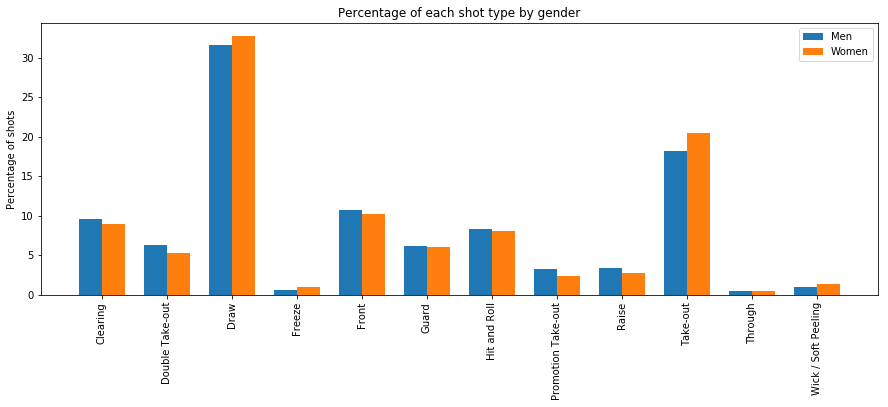

In [83]:
import numpy as np
labels = men_type_percent.index.values
n_labels = len(labels)
men_pct = men_type_percent.values
women_pct = women_type_percent.values

#The label locations
x = np.arange(n_labels)

#The width of the bars.
width = 0.35

#Make the plot
fig, ax = plt.subplots(figsize=(15,5))
men_plt = ax.bar(x-width/2, men_pct, width, label='Men')
women_plt = ax.bar(x + width/2, women_pct, width, label = 'Women')

#Add in the labels titles, and legend.
ax.set_ylabel("Percentage of shots")
ax.set_title("Percentage of each shot type by gender")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

Visually, the percentage of each type of shot is remarkably similar for Men and Women.  Draws and Take-outs are by far the most popular type of shot, and contrary to the stereotype, women call Take-outs more than Men, on average.

This plot also shows a potential issue with the proposed "Hit vs. Not Hit" analysis: Although women have called more Take-outs, Men have called visibly more Clearing, Double Take-out, and Promotion Take-outs.  Combining these together into Hit/No Hit washes out this information.  It may nonetheless still be an interesting avenue of inquiry.

Before we get to that, let's perform the $\chi^{2}$ test on this shot type data.

In [85]:
men_type_counts = men_types.groupby("shot_type")["game_type"].count().values
men_type_counts

array([ 8966,  5838, 29441,   568, 10042,  5806,  7756,  3044,  3187,
       16997,   479,   988])

In [87]:
women_type_counts = women_types.groupby("shot_type")["game_type"].count().values
women_type_counts

array([ 7643,  4516, 27758,   866,  8677,  5174,  6900,  2005,  2344,
       17383,   416,  1136])

In [88]:
#I will use chi2_contingency from scipy.stats to perform this computation.
from scipy.stats import chi2_contingency

#Make the contingency table out of this data.
cont_table = np.array([men_type_counts, women_type_counts])
cont_table

array([[ 8966,  5838, 29441,   568, 10042,  5806,  7756,  3044,  3187,
        16997,   479,   988],
       [ 7643,  4516, 27758,   866,  8677,  5174,  6900,  2005,  2344,
        17383,   416,  1136]])

In [89]:
chi2_contingency(cont_table)

(547.4835720386225,
 2.3539807626667085e-110,
 11,
 array([[ 8691.60460855,  5418.31983364, 29932.63242848,   750.42212106,
          9795.78220649,  5745.90996459,  7669.58619682,  2642.17663126,
          2894.41056595, 17991.29185635,   468.35969201,  1111.50389479],
        [ 7917.39539145,  4935.68016636, 27266.36757152,   683.57787894,
          8923.21779351,  5234.09003541,  6986.41380318,  2406.82336874,
          2636.58943405, 16388.70814365,   426.64030799,  1012.49610521]]))

The p-value computed by the $\chi^{2}$ test is $2\times10^{-110}$, so effectively $p = 0$.  We therefore conclude that there is a statistically significant difference in the shots called in Men's and Women's games.  Although the differences in percentages shown in the plot don't look very large, they correspond to large differences in counts of each type, which are unlikely to be due to random fluctuations.

That said, we need to put this in perspective.  Looking at the plot, overall the difference between Men and Women shot types called is rather small.  In a 10 end game, a team throws a total of 80 shots.  If it were a Men's team, we would expect:

In [93]:
80*men_type_percent/100

shot_type
Clearing                7.703411
Double Take-out         5.015895
Draw                   25.295128
Freeze                  0.488014
Front                   8.627889
Guard                   4.988401
Hit and Roll            6.663803
Promotion Take-out      2.615345
Raise                   2.738208
Take-out               14.603488
Through                 0.411547
Wick / Soft Peeling     0.848870
Name: game_type, dtype: float64

For women:

In [94]:
80*women_type_percent/100

shot_type
Clearing                7.208847
Double Take-out         4.259473
Draw                   26.181235
Freeze                  0.816808
Front                   8.184112
Guard                   4.880096
Hit and Roll            6.508053
Promotion Take-out      1.891108
Raise                   2.210851
Take-out               16.395576
Through                 0.392370
Wick / Soft Peeling     1.071471
Name: game_type, dtype: float64

This is the effectively the same number of each type of shot, whether it is men or women playing.  However, since we have such a large number of shots in our data sample, even though this difference is rather small, it is statistically significant.

To understand this difference, let's put it in terms of the ratio of Women:Men percent of each shot type called.

In [95]:
ratio_type_percent = women_type_percent/men_type_percent
ratio_type_percent

shot_type
Clearing               0.935799
Double Take-out        0.849195
Draw                   1.035031
Freeze                 1.673737
Front                  0.948565
Guard                  0.978289
Hit and Roll           0.976627
Promotion Take-out     0.723082
Raise                  0.807408
Take-out               1.122716
Through                0.953401
Wick / Soft Peeling    1.262232
Name: game_type, dtype: float64

In this case, the only categories that really stand out are:
* Freeze: Women are 67% more likely to call a Freeze (perhaps the most finessed shot) than Men.
* Promotion Take-out: Women are 28% less likely to call a Promotion Take-out than Men (a tricky hit to pull off).
* Wick / Soft Peeling: Women are 26% more likely to call a Wick / Soft Peeling than Men.

It should be noted though that all of these are relatively uncommon shots to call (based on their frequency, you'd expect to see less than 1 of each of them per game per team.)

So, as we concluded earlier, the strategies are statistically significantly different, but this doesn't translate to a difference you would notice in a given game.  To see this, we can perform a $\chi^{2}$ test on the shots one would expect in a given game.

In [99]:
game_cont_table = np.array([(80*men_type_percent/100).values, (80*women_type_percent/100).values])
game_cont_table

array([[ 7.70341095,  5.01589484, 25.29512845,  0.48801443,  8.62788899,
         4.98840107,  6.66380273,  2.61534496,  2.73820775, 14.60348827,
         0.41154738,  0.84887018],
       [ 7.20884718,  4.25947323, 26.18123512,  0.81680775,  8.18411186,
         4.88009621,  6.50805254,  1.89110802,  2.21085147, 16.39557641,
         0.39236954,  1.07147068]])

In [100]:
chi2_contingency(game_cont_table)

(0.49338728193594805,
 0.9999987199503799,
 11,
 array([[ 7.45612906,  4.63768403, 25.73818178,  0.65241109,  8.40600043,
          4.93424864,  6.58592763,  2.25322649,  2.47452961, 15.49953234,
          0.40195846,  0.96017043],
        [ 7.45612906,  4.63768403, 25.73818178,  0.65241109,  8.40600043,
          4.93424864,  6.58592763,  2.25322649,  2.47452961, 15.49953234,
          0.40195846,  0.96017043]]))

In [197]:
#How about for an event of 100 games?
event_cont_table = np.array([(8000*men_type_percent/100).values, (8000*women_type_percent/100).values])
event_cont_table

array([[ 770.3410946 ,  501.58948363, 2529.51284475,   48.80144342,
         862.78889939,  498.84010654,  666.38027322,  261.53449609,
         273.82077498, 1460.34882722,   41.15473838,   84.88701779],
       [ 720.88471787,  425.9473225 , 2618.12351152,   81.68077531,
         818.4111863 ,  488.0096206 ,  650.8052536 ,  189.11080195,
         221.08514702, 1639.55764107,   39.23695442,  107.14706784]])

In [198]:
chi2_contingency(event_cont_table)

(49.33872819359479,
 8.227301010191273e-07,
 11,
 array([[ 745.61290623,  463.76840307, 2573.81817813,   65.24110937,
          840.60004285,  493.42486357,  658.59276341,  225.32264902,
          247.452961  , 1549.95323414,   40.1958464 ,   96.01704281],
        [ 745.61290623,  463.76840307, 2573.81817813,   65.24110937,
          840.60004285,  493.42486357,  658.59276341,  225.32264902,
          247.452961  , 1549.95323414,   40.1958464 ,   96.01704281]]))

So on the level of a single game's worth of shots, $p = 1$.  So the difference between the shots called by Men and Women does not produce a statistically significant difference in the overall shot composition of a game.  In other words, your average curling game viewer should be unable to observe a difference between the frequency of the different types of shots called for Men and Women.

However, on the scale of a 100 game tournament, $p = 0$, so this difference would be observable.

### Conclusion
There is a statistically significant difference between the types of shots called by Men and Women.  However, this difference is small enough that it would not produce a statistically significant difference observable on a game to game basis though.  It would on the scale of a 100 game tournament though.

## Shot Type Analysis: Hit vs. Not Hit
The previous shot type analysis already casts significant doubt on the veracity of the "Men like to hit more than Women" stereotype.  Let's now use the "is_hit" column we generated to make the more coarse grained Hit vs. Not Hit comparison.

In [108]:
men_is_hit = men_types.groupby("is_hit")["game_type"].count()
men_is_hit

is_hit
False    50511
True     42601
Name: game_type, dtype: int64

In [109]:
women_is_hit = women_types.groupby("is_hit")["game_type"].count()
women_is_hit

is_hit
False    46371
True     38447
Name: game_type, dtype: int64

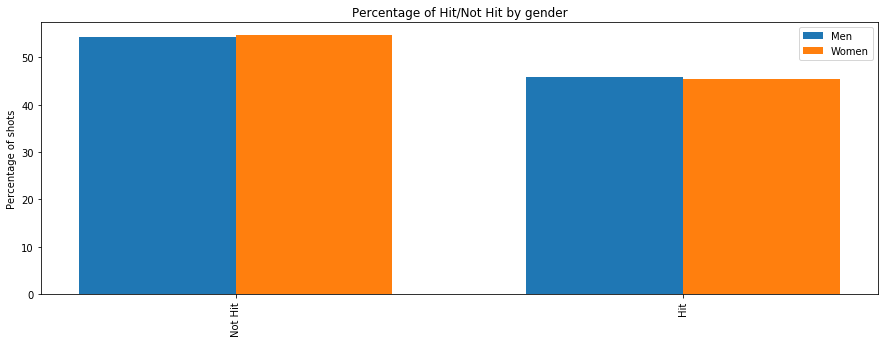

In [121]:
labels2 = ["Not Hit", "Hit"]
n_labels = len(labels2)
men_hit_pct = 100*(men_is_hit.values)/n_men
women_hit_pct = 100*(women_is_hit.values)/n_women

#The label locations
x2 = np.arange(n_labels)

#The width of the bars.
width2 = 0.35

#Make the plot
fig2, ax2 = plt.subplots(figsize=(15,5))
men_hit_plt = ax2.bar(x2-width2/2, men_hit_pct, width2, label='Men')
women_hit_plt = ax2.bar(x2 + width2/2, women_hit_pct, width2, label = 'Women')

#Add in the labels titles, and legend.
ax2.set_ylabel("Percentage of shots")
ax2.set_title("Percentage of Hit/Not Hit by gender")
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2, rotation='vertical')
ax2.legend()

So, from this plot, with the categorization assumptions I made (including some technical "hits" as "not hits" due to them being considered more "finesse" shots), Men do have a SLIGHTLY larger percentage of their shots as hits than not hits.  What happens if we perform the $\chi^{2}$ test here?

In [119]:
hit_cont_table = np.array([men_is_hit.values, women_is_hit.values])
hit_cont_table

array([[50511, 42601],
       [46371, 38447]])

In [120]:
chi2_contingency(hit_cont_table)

(3.1942410718519225,
 0.0738980626180239,
 1,
 array([[50699.02087338, 42412.97912662],
        [46182.97912662, 38635.02087338]]))

So in this case, "Hit vs. Not Hit", $p = 0.07$, i.e. just big enough that we do not reject the null hypothesis that Men and Women hit with the same frequency.

If it's not a statistically significant difference over all games, it is definitely not a statistically significant difference on the level of 1 game.

### Conclusion
I do not find a statistically significant difference in the fraction of hits vs. not hits called by Men vs. Women.

# Analysis 2: Stones in Play
Both of the shot type analyses have already challenged the stereotype that there is more hitting in Men's games than Women's games.  Before we draw any final conclusions, I would like to pursue an alternate direction to take to answer this question:  Looking at the number of stones in play.  If the stereotype holds, the maximum number of rocks in each end should be lower for Men than for Women, if Men really prefer to "keep it clean" more than Women do.

To do this analysis, we need:
* type from the games table.
* The maximum number of stones in play in each end, from the stone_positions table.

For latter, we need a more complex SQL query to:
* Count the number of stone_positions for each shot.
* Take the maximum of those numbers for each end.

In [132]:
q = """
WITH stone_counts AS
(SELECT shots.end_id, stone_positions.shot_id, COUNT(stone_positions.x) AS stone_count FROM stone_positions 
INNER JOIN shots ON shots.id = stone_positions.shot_id
GROUP BY shot_id)

SELECT games.type, MAX(stone_counts.stone_count) AS max_stones FROM stone_counts
INNER JOIN ends ON ends.id = stone_counts.end_id
INNER JOIN games ON games.id = ends.game_id
GROUP BY end_id
"""
stone_count_df = db.run_query(q)
stone_count_df

,type,max_stones
0,Men,5
1,Men,5
2,Men,6
3,Men,7
4,Men,7
5,Men,8
6,Men,5
7,Men,6
8,Men,6
9,Men,6


In [138]:
men_max_stone_counts = stone_count_df[stone_count_df["type"] == "Men"]
women_max_stone_counts = stone_count_df[stone_count_df["type"] == "Women"]

In [139]:
n_men_ends = men_max_stone_counts.shape[0]
n_men_ends

5986

In [141]:
n_women_ends = women_max_stone_counts.shape[0]
n_women_ends

5485

So, once again a similar number of men and women entries, but not equal.  We will use the "density = true" option in pyplot hist so that we are comparing two normalized probability densities for the distribution of maximum number of stones in play.

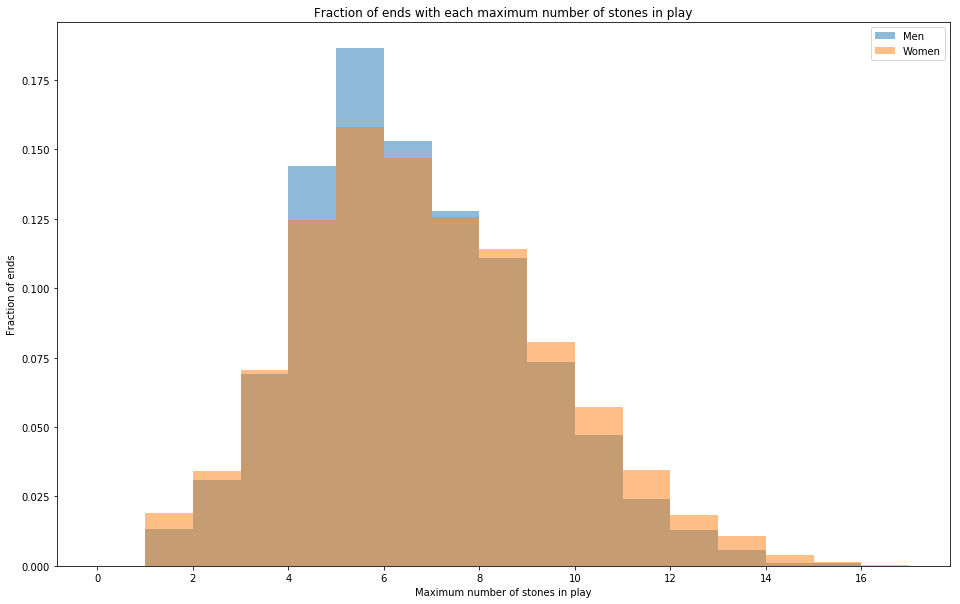

In [169]:
from matplotlib.ticker import MaxNLocator

fig3, ax3 = plt.subplots(figsize=(16,10))
men_max_plt = plt.hist(men_max_stone_counts["max_stones"], density=True, bins=np.arange(0,18),alpha=0.5, label="Men")
women_max_plt = plt.hist(women_max_stone_counts["max_stones"], density=True, bins=np.arange(0,18),alpha=0.5, label="Women")
ax3.set_ylabel("Fraction of ends")
ax3.set_xlabel("Maximum number of stones in play")
ax3.set_title("Fraction of ends with each maximum number of stones in play")
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.legend()

This figure does show a broader distribution for the maximum number of stones in play in an end for the women, with the difference largely appearing at higher values.  As before, we will convert this information into a contingency table, and perform a $\chi^{2}$ test to see whether these distributions are statistically significantly different.

Also as before, we need to check to what extent this difference would manifest in a game, because although there is a visible difference, these distributions are remarkably similar.

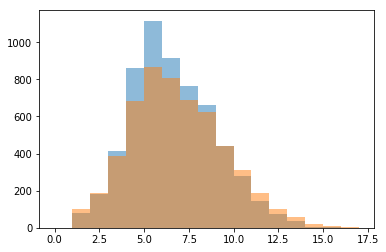

In [173]:
#Use pyplot's hist to bin the data as in the histogram (Note that the histogram that shows up does not have each plot
#normalized, so the plot will look different.)
men_max_counts = plt.hist(men_max_stone_counts["max_stones"], bins=np.arange(0,18),alpha=0.5, label="Men")
women_max_counts = plt.hist(women_max_stone_counts["max_stones"], bins=np.arange(0,18),alpha=0.5, label="Women")

In [175]:
men_max_counts[0]

array([   0.,   79.,  184.,  413.,  862., 1116.,  916.,  764.,  664.,
        439.,  281.,  144.,   77.,   35.,    6.,    6.,    0.])

In [176]:
women_max_counts[0]

array([  0., 104., 188., 386., 684., 866., 806., 689., 626., 442., 313.,
       189., 101.,  59.,  22.,   8.,   2.])

In [177]:
#We can use the same contingency table chi squared function with this data as we used for the shot type data.
max_cont = np.array([men_max_counts[0], women_max_counts[0]])
max_cont

array([[   0.,   79.,  184.,  413.,  862., 1116.,  916.,  764.,  664.,
         439.,  281.,  144.,   77.,   35.,    6.,    6.,    0.],
       [   0.,  104.,  188.,  386.,  684.,  866.,  806.,  689.,  626.,
         442.,  313.,  189.,  101.,   59.,   22.,    8.,    2.]])

In [191]:
#We need to remove the first zero entry, because the chi squared function doesn't handle zero expected frequency
#(produces an error).
max_cont = np.array([np.delete(men_max_counts[0], 0), np.delete(women_max_counts[0], 0)])
chi2_contingency(max_cont)

(75.28572410643835,
 5.027359752859968e-10,
 15,
 array([[9.54962950e+01, 1.94123616e+02, 4.16948304e+02, 8.06761050e+02,
         1.03428228e+03, 8.98604481e+02, 7.58230146e+02, 6.73170604e+02,
         4.59738994e+02, 3.09971581e+02, 1.73771947e+02, 9.28871066e+01,
         4.90527417e+01, 1.46114550e+01, 7.30572749e+00, 1.04367536e+00],
        [8.75037050e+01, 1.77876384e+02, 3.82051696e+02, 7.39238950e+02,
         9.47717723e+02, 8.23395519e+02, 6.94769854e+02, 6.16829396e+02,
         4.21261006e+02, 2.84028419e+02, 1.59228053e+02, 8.51128934e+01,
         4.49472583e+01, 1.33885450e+01, 6.69427251e+00, 9.56324645e-01]]))

So for the Men and Women distributions of maximum number of stones in play in each end, we also have a p-value of essentially zero, so the difference apparent in the histogram is statistically significant.

However, as before, the real question is, are these distributions different enough that on the level of one game the game viewer would be able to notice the difference if they counted the maximum number of stones in play.  We can take the distributions shown in the plot, use it to produce what we would see for a 10 end game played by Men and Women, and check for statistical significance there.

In [193]:
men_game_max = 10*men_max_plt[0]
men_game_max

array([0.        , 0.13197461, 0.3073839 , 0.6899432 , 1.44002673,
       1.86435015, 1.53023722, 1.27631139, 1.10925493, 0.73337788,
       0.46942867, 0.24056131, 0.12863348, 0.05846976, 0.01002339,
       0.01002339, 0.        ])

In [194]:
women_game_max = 10*women_max_plt[0]
women_game_max

array([0.        , 0.18960802, 0.34275296, 0.70373747, 1.24703737,
       1.57885141, 1.46946217, 1.25615314, 1.14129444, 0.80583409,
       0.57064722, 0.34457612, 0.18413856, 0.10756609, 0.04010939,
       0.01458523, 0.00364631])

In [195]:
game_max_cont = np.array([np.delete(men_game_max, 0), np.delete(women_game_max, 0)])
chi2_contingency(game_max_cont)

(0.13043701956774909,
 0.9999999999999137,
 15,
 array([[0.16079131, 0.32506843, 0.69684033, 1.34353205, 1.72160078,
         1.49984969, 1.26623227, 1.12527468, 0.76960599, 0.52003794,
         0.29256871, 0.15638602, 0.08301793, 0.02506639, 0.01230431,
         0.00182315],
        [0.16079131, 0.32506843, 0.69684033, 1.34353205, 1.72160078,
         1.49984969, 1.26623227, 1.12527468, 0.76960599, 0.52003794,
         0.29256871, 0.15638602, 0.08301793, 0.02506639, 0.01230431,
         0.00182315]]))

As we'd expect for this low level of statistics, the p-value is essentially equal to 1.  So on the level of 1 game of 10 ends, we wouldn't expect to notice a difference between Men and Women in terms of maximum number of stones in play.  What if we looked at 100 games, being maybe more representative of a large event?

In [196]:
event_max_cont = np.array([np.delete(100*men_game_max, 0), np.delete(100*women_game_max, 0)])
chi2_contingency(event_max_cont)

(13.04370195677491,
 0.5989223044448491,
 15,
 array([[ 16.07913146,  32.50684292,  69.68403333, 134.35320518,
         172.16007816, 149.98496949, 126.62322691, 112.52746838,
          76.96059874,  52.00379433,  29.25687132,  15.63860189,
           8.30179261,   2.50663886,   1.23043102,   0.18231541],
        [ 16.07913146,  32.50684292,  69.68403333, 134.35320518,
         172.16007816, 149.98496949, 126.62322691, 112.52746838,
          76.96059874,  52.00379433,  29.25687132,  15.63860189,
           8.30179261,   2.50663886,   1.23043102,   0.18231541]]))

Here, $p = 0.6$.  So even if looking at a whole tournament full of games, looking at the maximum number of stones in play in each end, one would not be able to distinguish between Men and Women.

### Conclusion
As before, there is a statistically significant difference between Men's and Women's games in terms of the maximum number of stones in play, but this difference is not large enough to manifest on the scale of a game or even a whole tournament.

# Overall Conclusions and Next Steps
We've examined the stereotype that Men's curling teams prefer to hit more than Women's curling teams from two directions:
1. Differences in the shots called between Men and Women (both by shot type, and whether it is considered a hit or not).
2. Differences in the maximum number of stones in play in an end between Men and Women.

In both cases, there are statistically significant differences between Men's and Women's games.  However, on the scale of a single game there would not be a statistically significant difference between a Men's game and a Women's game.  This is true even for a 100 game event in the case of the maximum number of stones in play, though at that number of games the difference in shots called would be statistically significant.

So what does this mean for the stereotype that Men prefer to hit more than Women?  I once had a curling coach who claimed that he liked to watch Women's games more than Men's games, because they had more interesting shots due to less hitting and more rocks in play.  That led me to expect a very large difference, which the data does not appear to show.

However, it's possible that these analyses were too simplistic to capture differences that were more obvious.  What if shot type is broken down by shot number?  (The first stone is almost always of type Front, and Guards and Draws are common in most strategies at the beginning of the end, during the 4 rock free guard zone.)  Do more/less aggressive strategies appear at different points in the end?  Also, Men or Women, a team trying to hang onto a lead is going to try and "keep it clean", limiting the number of rocks in play.  (So the score differential may be important to consider.)

Also, as any coach will remind a rookie skip, "Calling the shot is one thing, making it is another".  Is there a difference in shot accuracy between men and women that depends on shot type?  How does this impact the number of stones in play?  There may also be value in considering a 2D distribution of number of stones in play vs. shot in the end, to get more fine-grained information than just the maximum.  Differences here might be readily apparent to a game viewer, but have been washed out in these simple analyses.  Stay tuned for a deeper more complex look into these questions!